## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [4]:
#Let's select validation part from train dataset
fmnist_train, fmnist_valid = torch.utils.data.random_split(fmnist_dataset_train, [50000, 10000])

In [5]:
train_loader = torch.utils.data.DataLoader(fmnist_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
val_loader = torch.utils.data.DataLoader(fmnist_valid, 
                                           batch_size=256,
                                           shuffle=False,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [6]:
for img, label in train_loader:
    print(img.shape)
    # print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [8]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

    def __call__(self, inp):
        return self.forward(inp)

In [9]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
       BatchNorm1d-3                  [-1, 256]             512
         LeakyReLU-4                  [-1, 256]               0
           Dropout-5                  [-1, 256]               0
            Linear-6                   [-1, 10]           2,570
Total params: 204,042
Trainable params: 204,042
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.78
Estimated Total Size (MB): 0.80
----------------------------------------------------------------


Your experiments come here:

In [10]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here

In [11]:
def train_torch_model(model, train_loader, val_loader, loss_fn, n_epochs, opt):

    train_loss = []
    val_loss = []
    val_accuracy = []
    best_val_loss = None
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []

        model.train(True) # turn on dropout and batch_norm training mode
        for X_batch, y_batch in train_loader:
            opt.zero_grad()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            out = model(X_batch)
            loss = loss_fn(out, y_batch)
            
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())

        model.train(False) # turn off dropout and batch_norm training mode
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                out = model(X_batch)
                loss = loss_fn(out, y_batch)
                
                ep_val_loss.append(loss.item())
                y_pred = out.max(dim=1)[1]
                ep_val_accuracy.append(np.sum((y_pred.cpu() == y_batch.cpu()).numpy())/len(y_batch.cpu().numpy()))

        print(f'Epoch {epoch + 1} of {n_epochs}')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

        if best_val_loss is None or best_val_loss > val_loss[-1]:
            print(f'Best model yet, saving')
            best_val_loss = val_loss[-1]
            torch.save(model, './best_model.pth')

    return train_loss, val_loss, val_accuracy

In [12]:
n_epochs = 20
train_loss, val_loss, val_accuracy = train_torch_model(model, train_loader,
                                                 val_loader, loss_func,
                                                 n_epochs, opt)

Epoch 1 of 20
	  training loss: 0.579215
	validation loss: 0.407790
	validation accuracy: 0.853
Best model yet, saving
Epoch 2 of 20
	  training loss: 0.443236
	validation loss: 0.379119
	validation accuracy: 0.863
Best model yet, saving
Epoch 3 of 20
	  training loss: 0.412256
	validation loss: 0.368254
	validation accuracy: 0.863
Best model yet, saving
Epoch 4 of 20
	  training loss: 0.388331
	validation loss: 0.355652
	validation accuracy: 0.867
Best model yet, saving
Epoch 5 of 20
	  training loss: 0.371303
	validation loss: 0.346879
	validation accuracy: 0.868
Best model yet, saving
Epoch 6 of 20
	  training loss: 0.359099
	validation loss: 0.335053
	validation accuracy: 0.876
Best model yet, saving
Epoch 7 of 20
	  training loss: 0.346279
	validation loss: 0.327880
	validation accuracy: 0.877
Best model yet, saving
Epoch 8 of 20
	  training loss: 0.336357
	validation loss: 0.323106
	validation accuracy: 0.879
Best model yet, saving
Epoch 9 of 20
	  training loss: 0.330035
	valida

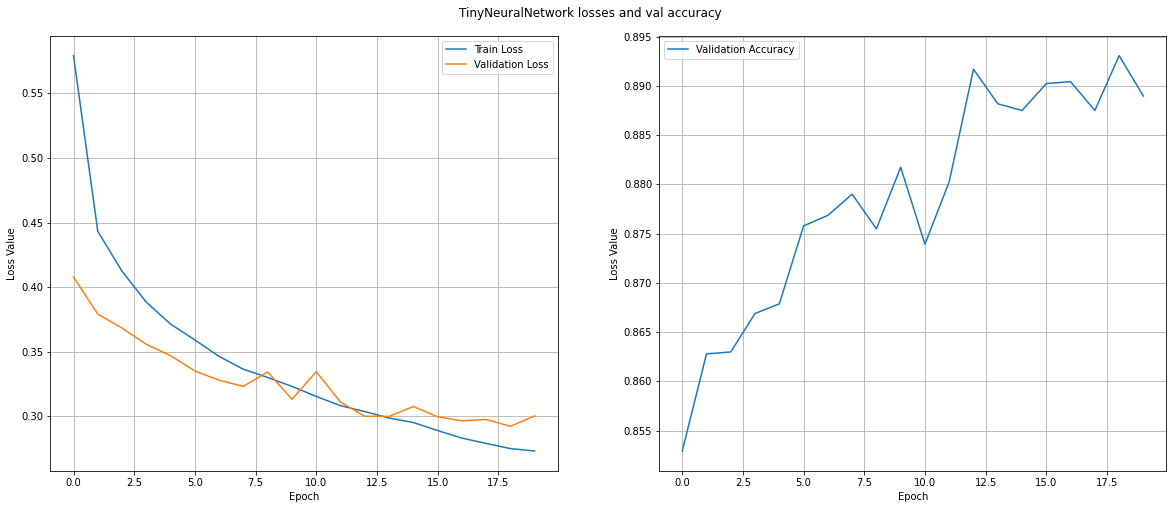

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20,8));
fig.suptitle('TinyNeuralNetwork losses and val accuracy', y=0.93)
ax[0].plot(train_loss, label = 'Train Loss')
ax[0].plot(val_loss, label = 'Validation Loss')
ax[1].plot(val_accuracy, label = 'Validation Accuracy')
for i in range(2):
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Loss Value')
    ax[i].grid(which='major')
    ax[i].legend();

In [15]:
model = torch.load('./best_model.pth')
with torch.no_grad():
    model.train(False)

    y_pred = np.array([])
    y_label = np.array([])

    for X_batch, y_batch in test_loader:
        out = model.forward(X_batch.to(device))

        y_pred = np.concatenate((y_pred, out.argmax(axis=1).cpu().numpy()))
        y_label = np.concatenate((y_label, y_batch.cpu().numpy()))

    print("Accuracy on test data = ", np.mean(y_label == y_pred))

Accuracy on test data =  0.8864


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [21]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

    def __call__(self, inp):
        return self.forward(inp)

In [22]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                   [-1, 10]           2,570
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.04
Estimated Total Size (MB): 2.06
----------------------------------------------------------------


In [23]:
model_over = OverfittingNeuralNetwork().to(device)
opt_over = torch.optim.SGD(model_over.parameters(), lr=1e-2, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

In [24]:
n_epochs = 30
train_loss, val_loss, val_accuracy = train_torch_model(model_over, train_loader,
                                                 val_loader, loss_func,
                                                 n_epochs, opt_over)

Epoch 1 of 30
	  training loss: 0.870846
	validation loss: 0.505185
	validation accuracy: 0.826
Best model yet, saving
Epoch 2 of 30
	  training loss: 0.487859
	validation loss: 0.460625
	validation accuracy: 0.835
Best model yet, saving
Epoch 3 of 30
	  training loss: 0.439905
	validation loss: 0.413705
	validation accuracy: 0.850
Best model yet, saving
Epoch 4 of 30
	  training loss: 0.403211
	validation loss: 0.383642
	validation accuracy: 0.860
Best model yet, saving
Epoch 5 of 30
	  training loss: 0.377253
	validation loss: 0.373997
	validation accuracy: 0.861
Best model yet, saving
Epoch 6 of 30
	  training loss: 0.355973
	validation loss: 0.358217
	validation accuracy: 0.865
Best model yet, saving
Epoch 7 of 30
	  training loss: 0.340995
	validation loss: 0.336228
	validation accuracy: 0.878
Best model yet, saving
Epoch 8 of 30
	  training loss: 0.328451
	validation loss: 0.355923
	validation accuracy: 0.868
Epoch 9 of 30
	  training loss: 0.313426
	validation loss: 0.316931
	va

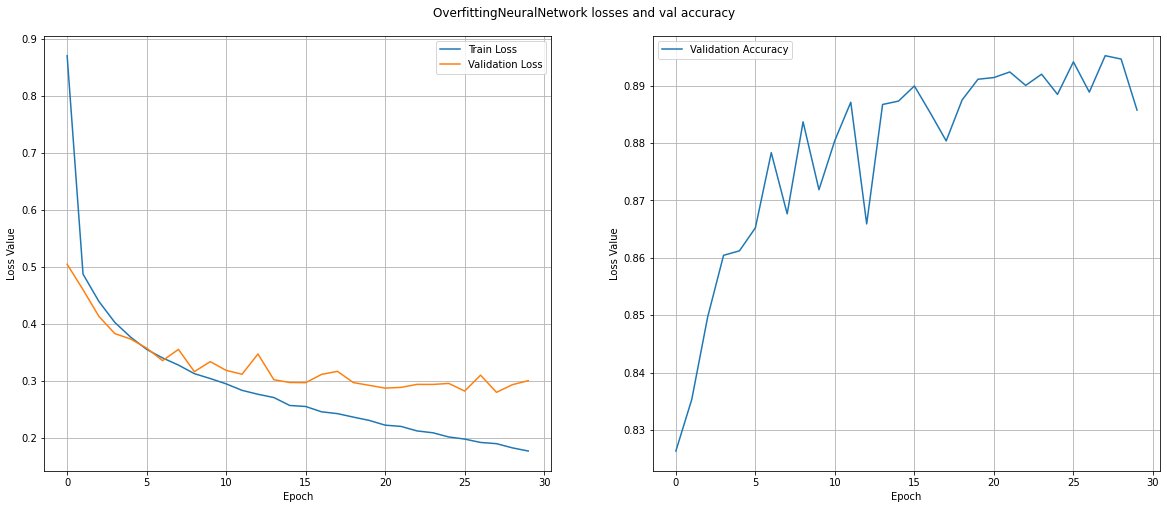

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(20,8));
fig.suptitle('OverfittingNeuralNetwork losses and val accuracy', y=0.93)
ax[0].plot(train_loss, label = 'Train Loss')
ax[0].plot(val_loss, label = 'Validation Loss')
ax[1].plot(val_accuracy, label = 'Validation Accuracy')
for i in range(2):
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Loss Value')
    ax[i].grid(which='major')
    ax[i].legend();

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [26]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes)      
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

    def __call__(self, inp):
        return self.forward(inp)

In [27]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
       BatchNorm1d-3                  [-1, 512]           1,024
              ReLU-4                  [-1, 512]               0
           Dropout-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
       BatchNorm1d-7                  [-1, 256]             512
              ReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 537,354
Trainable params: 537,354
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.05
Estimated T

In [28]:
model_fix = FixedNeuralNetwork().to(device)
opt_fix = torch.optim.SGD(model_fix.parameters(), lr=1e-2, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

In [29]:
n_epochs = 30
train_loss, val_loss, val_accuracy = train_torch_model(model_fix, train_loader,
                                                 val_loader, loss_func,
                                                 n_epochs, opt_fix)

Epoch 1 of 30
	  training loss: 0.626378
	validation loss: 0.398773
	validation accuracy: 0.850
Best model yet, saving
Epoch 2 of 30
	  training loss: 0.460595
	validation loss: 0.365281
	validation accuracy: 0.867
Best model yet, saving
Epoch 3 of 30
	  training loss: 0.420167
	validation loss: 0.343400
	validation accuracy: 0.874
Best model yet, saving
Epoch 4 of 30
	  training loss: 0.396263
	validation loss: 0.335302
	validation accuracy: 0.875
Best model yet, saving
Epoch 5 of 30
	  training loss: 0.378925
	validation loss: 0.323309
	validation accuracy: 0.879
Best model yet, saving
Epoch 6 of 30
	  training loss: 0.366778
	validation loss: 0.326422
	validation accuracy: 0.880
Epoch 7 of 30
	  training loss: 0.351943
	validation loss: 0.310130
	validation accuracy: 0.881
Best model yet, saving
Epoch 8 of 30
	  training loss: 0.344543
	validation loss: 0.304004
	validation accuracy: 0.889
Best model yet, saving
Epoch 9 of 30
	  training loss: 0.335432
	validation loss: 0.322228
	va

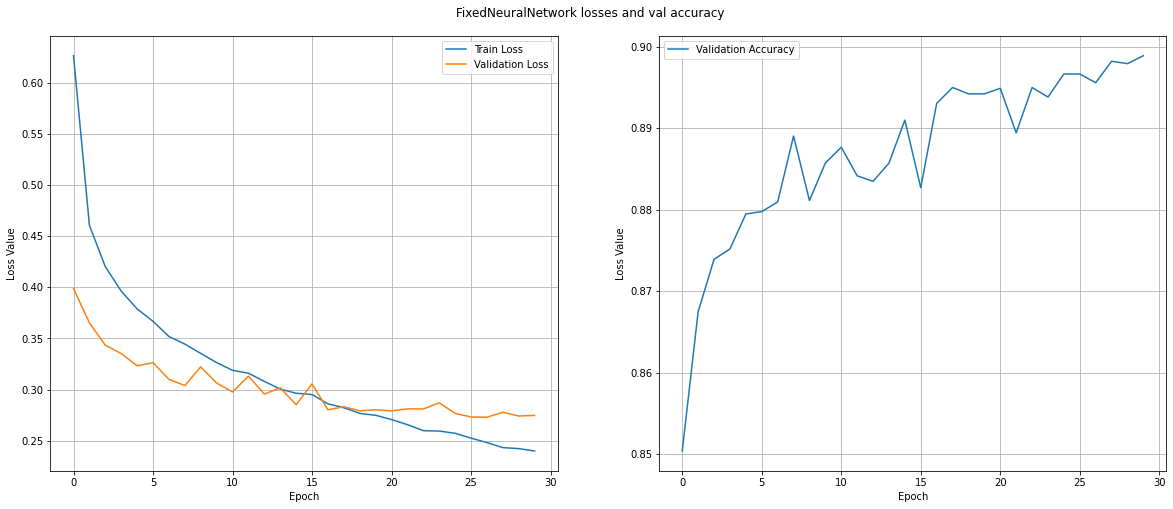

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20,8));
fig.suptitle('FixedNeuralNetwork losses and val accuracy', y=0.93)
ax[0].plot(train_loss, label = 'Train Loss')
ax[0].plot(val_loss, label = 'Validation Loss')
ax[1].plot(val_accuracy, label = 'Validation Accuracy')
for i in range(2):
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Loss Value')
    ax[i].grid(which='major')
    ax[i].legend();

In [31]:
model_fix = torch.load('./best_model.pth')
with torch.no_grad():
    model_fix.train(False)

    y_pred = np.array([])
    y_label = np.array([])

    for X_batch, y_batch in test_loader:
        out = model_fix.forward(X_batch.to(device))

        y_pred = np.concatenate((y_pred, out.argmax(axis=1).cpu().numpy()))
        y_label = np.concatenate((y_label, y_batch.cpu().numpy()))

    print("Accuracy on test data = ", np.mean(y_label == y_pred))

Accuracy on test data =  0.8887


### Conclusions:
_Write down small report with your conclusions and your ideas._

- In the first task we created a simple grid, in the process of training on the validation data we selected the best model and obtained the desired result on the test data.
- The next task was to retrain the model, I left only the linear layers and activation functions, so the network began to retrain as the epochs increased, you can see the beginning of overfitting on the graphs. The loss of validation data stops falling and then begins to grow, while the loss of train data continues to fall. The model has started to remember the training sample.
- In the last point, we try to fix the sad situation. We add a BatchNorm after the linear layers and apply a Dropout. BatchNorm and Dropout speed up learning and are excellent regularizers. Dropout prevents units from co-adapting too much. 
- On the graphs of the improved model, you can notice both the acceleration of training and the same decrease in the loss curves.

**In summary:** BatchNorm and Dropouts are an essential part of neural network to speed up convergence and prevent overfitting.